In [1]:
## Overview 

In [1]:
### Import Libraries
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import time
import sys
sys.path.insert(0,'../../../../../utils')
from helper_functions_genus import *
#import helper_function custom library
from model_builder_genus import ModelBuilder
pd.options.mode.chained_assignment = None
%matplotlib inline 

In [2]:
### Import Data and Clean Data


In [3]:
#load spectra data
df_aug = pd.read_csv("../../../../../data/refCanopies0802_0630.txt")
df_sep = pd.read_csv("../../../../../data/refCanopies0917_0630.txt")
df_oct = pd.read_csv("../../../../../data/refCanopies1016_0630.txt")

#load tree data
df_tree = pd.read_csv("../../../../../data/Export_Output_2_0630_Genus.txt")

In [4]:
#clean data
#removes non-vegatation pixels, tRef.NDVI = (tRef.x800_67 - tRef.x679_92) ./ (tRef.x800_67 + tRef.x679_92)
#removes shaded or dark pixels as well, (pixel's reflectance@800_67 <=0.15)
df_aug = data_cleaning(df_tree,df_aug)
df_sep = data_cleaning(df_tree,df_sep)
df_oct = data_cleaning(df_tree,df_oct)

In [5]:
### Merge Data and Split Data

In [6]:
#merge data
#column-wise left-join of the three datasets
#join August and September images by extracting common pixels (intersections)
df = merge_images([df_aug,df_sep,df_oct])

In [7]:
### No Dimesion Reduction

In [8]:
#split data 
#features (spectra)
X = df[df.columns[3:]].values
#predictor/target(tree species class)
y = LabelEncoder().fit_transform(df.TARGET) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101) #70:30 split, train-test

In [9]:
### Build A Model

In [10]:
model_name = "genus_hyper_merged_nd"
merge_nd = RandomForestClassifier(n_estimators = 100,verbose=1, oob_score = True)
merge_nd.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.9min finished


RandomForestClassifier(oob_score=True, verbose=1)

In [11]:
#evaluate the model
#create a confusion matrix
labels = ["Ash","Maple","Oak","Pine","Redbud","Spruce"]
nclasses = 6
evals = []

In [12]:
#save the model
save_model(merge_nd,model_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


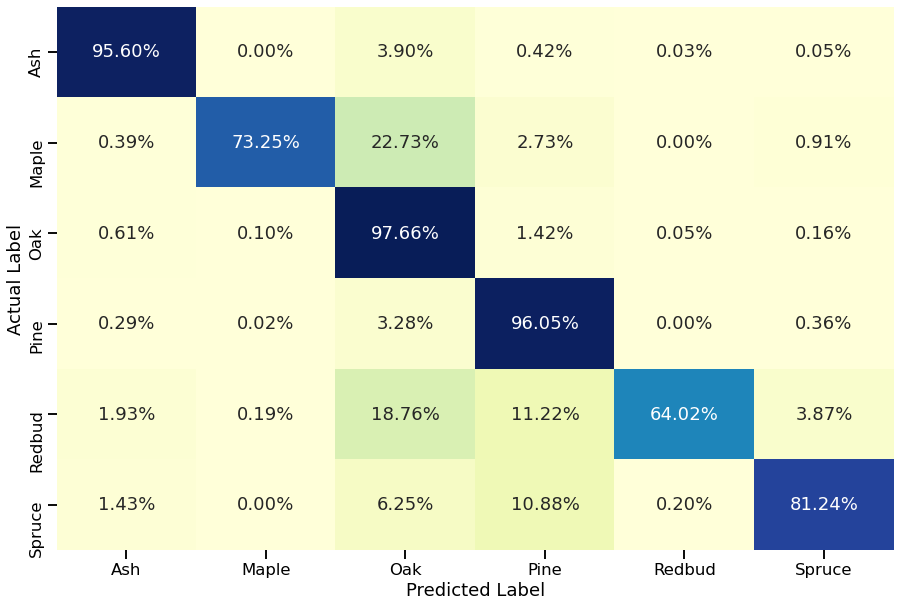

In [13]:
#metrics
train_preds = merge_nd.predict(X_train)
preds = merge_nd.predict(X_test)
train_accuracy = 100*(accuracy_score(train_preds,y_train))
test_accuracy = 100*(accuracy_score(y_test, preds))
generate_cf(model_name,y_test,preds,nclasses,labels)
merge_nd_results =pd.DataFrame.from_dict( {"Model":[model_name], "Train Accuracy(%)":[train_accuracy],
        "Test Accuracy(%)":[test_accuracy]})
evals.append(merge_nd_results)

In [14]:
###Dimension reduction with PCA

In [15]:
#split data 
#features (spectra)
merged_pcs = calculate_pcs(df,df[df.columns[3:]],30)
X = merged_pcs[merged_pcs.columns[:-1]].values
#predictor/target(tree species class)
y = LabelEncoder().fit_transform(merged_pcs.target) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101) #70:30 split, train-test

            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
71863 -1.952874 -0.958764  1.312716 -0.069740  0.010708  0.148872  0.058626   
71864 -1.901518 -1.066104  1.063700  0.047285  0.041115  0.123836  0.038125   
71865 -1.501070 -1.076446  0.426931  0.130130 -0.070472  0.088286  0.018858   
71866 -1.678345 -1.296387  1.208744  0.052900  0.034852  0.139969  0.044181   
71867 -1.277896 -1.306729  0.571975  0.135744 -0.076736  0.104419  0.024914   

            PC8       PC9      PC10  ...      PC22      PC23      PC24  \
71863  0.006275  0.074686 -0.003122  ...  0.003367 -0.014260  0.011722   
71864 -0.001333  0.064106 -0.000494  ... -0.004238 -0.018818  0.018004   
71865  0.006160  0.050848  0.022848  ... -0.004522 -0.020045  0.015750   
71866 -0.005007  0.053889 -0.000711  ... -0.008657 -0.017215  0.028647   
71867  0.002486  0.040631  0.022630  ... -0.008940 -0.018442  0.026393   

           PC25      PC26      PC27      PC28      PC29      PC30  target  
7186

In [16]:
#build a model with PCA
model_name = "genus_hyper_merged_pc"
merge_pc = RandomForestClassifier(n_estimators = 100,verbose=1, oob_score = True)
merge_pc.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.9s finished


RandomForestClassifier(oob_score=True, verbose=1)

In [17]:
#save the model
save_model(merge_pc,model_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


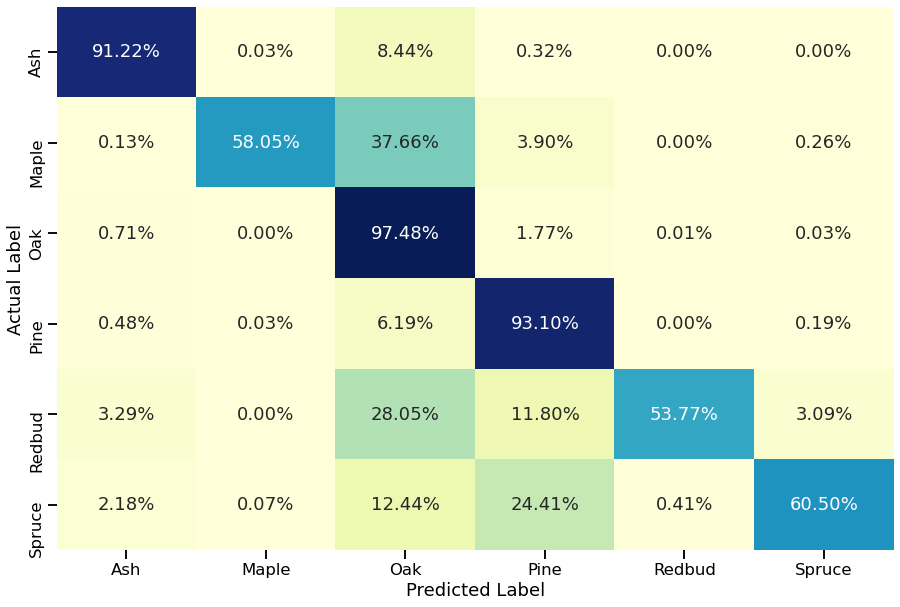

In [18]:
#metrics
train_preds = merge_pc.predict(X_train)
preds = merge_pc.predict(X_test)
train_accuracy = 100*(accuracy_score(train_preds,y_train))
test_accuracy = 100*(accuracy_score(y_test, preds))
generate_cf(model_name,y_test,preds,nclasses,labels)
merge_pc_results =pd.DataFrame.from_dict( {"Model":[model_name], "Train Accuracy(%)":[train_accuracy],
        "Test Accuracy(%)":[test_accuracy]})
evals.append(merge_pc_results)

In [19]:
#complile results
df_results = pd.concat(evals)
df_results

,Model,Train Accuracy(%),Test Accuracy(%)
0,genus_hyper_merged_nd,99.956269,94.063355
0,genus_hyper_merged_pc,99.954281,90.223088


In [20]:
df_results.to_csv('genus_hyper_merged_summary_results.csv')